# Load Packages

In [7]:

%load_ext autoreload
%autoreload 2

import sys
from os.path import join
from tqdm.auto import tqdm
import joblib
import torch
sys.path.append("../../")

from src.file_manager.load_data import load_split_dict
from src.file_processing.processing_predictions import load_prediction_df_dict, save_pi_df_dict
from src.file_manager.save_load_scaler import load_scaler
from src.pi_methods.knn import knn_prediction_interval
from src.pi_methods.weighted import weighted_prediction_interval
from src.pi_methods.cond_gaussian import cond_gauss_prediction_interval
from src.pi_methods.gaussian_copula import gauss_copula_prediction_interval
from src.pi_methods.conformal_prediction import conformal_prediction_interval
from src.evaluation.investigate_re_pe_distribution import investigate_re_n_pe_for_all_seeds, investigate_re_n_pe
from src.misc import create_folder
from ue_pi_dicts import ue_dict
# from seed_file import seed
from src.evaluation.knn_ablation import knn_ablation, display_knn_ablation

seed = 2023
data_label = "mimic"
batch_size = 64

# File paths
fp_notebooks_folder = "../"
fp_project_folder = join(fp_notebooks_folder, "../")
fp_data_folder = join(fp_project_folder, "../", "data")
fp_processed_folder = join(fp_project_folder, "processed_data", data_label)
fp_output_data_folder = join(fp_data_folder, data_label)
fp_checkpoint_folder = join(fp_project_folder, "checkpoints")
fp_project_checkpoints = join(fp_checkpoint_folder, data_label)
fp_tuning = join(fp_project_checkpoints, "tuning")
fp_models = join(fp_project_checkpoints, "models")
fp_predictions = join(fp_project_checkpoints, "predictions")
fp_pi_predictions = join(fp_project_checkpoints, "pi_predictions")
fp_ablation_folder = join(fp_project_checkpoints, "knn_ablation")

pred_file_names =  ["rue", "gpr", "infernoise", "der", "bnn"]
fp_cur_predictions_folder = join(fp_predictions, str(seed))
fp_cur_ablation_folder = join(fp_ablation_folder, str(seed))
create_folder(fp_cur_ablation_folder)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [4]:
split_dict = joblib.load(join(fp_processed_folder, "mimic_split_dict.joblib"))
split_dict["target_cols"] = {
    time_label: time_info["outputs"] for time_label, time_info in split_dict.items()
}
split_dict["feat_cols"] = ['ABPdias (mmHg)_mean Min0', 'RESP (bpm)_mean Min0', 'ABPmean (mmHg)_mean Min0', 'ABPsys (mmHg)_mean Min0', 'SpO2 (%)_mean Min0', 'HR (bpm)_mean Min0', 'ABPdias (mmHg)_std Min0', 'RESP (bpm)_std Min0', 'ABPmean (mmHg)_std Min0', 'ABPsys (mmHg)_std Min0', 'SpO2 (%)_std Min0', 'HR (bpm)_std Min0', 'ABPdias (mmHg)_mean Min1', 'RESP (bpm)_mean Min1', 'ABPmean (mmHg)_mean Min1', 'ABPsys (mmHg)_mean Min1', 'SpO2 (%)_mean Min1', 'HR (bpm)_mean Min1', 'ABPdias (mmHg)_std Min1', 'RESP (bpm)_std Min1', 'ABPmean (mmHg)_std Min1', 'ABPsys (mmHg)_std Min1', 'SpO2 (%)_std Min1', 'HR (bpm)_std Min1', 'ABPdias (mmHg)_mean Min2', 'RESP (bpm)_mean Min2', 'ABPmean (mmHg)_mean Min2', 'ABPsys (mmHg)_mean Min2', 'SpO2 (%)_mean Min2', 'HR (bpm)_mean Min2', 'ABPdias (mmHg)_std Min2', 'RESP (bpm)_std Min2', 'ABPmean (mmHg)_std Min2', 'ABPsys (mmHg)_std Min2', 'SpO2 (%)_std Min2', 'HR (bpm)_std Min2', 'ABPdias (mmHg)_mean Min3', 'RESP (bpm)_mean Min3', 'ABPmean (mmHg)_mean Min3', 'ABPsys (mmHg)_mean Min3', 'SpO2 (%)_mean Min3', 'HR (bpm)_mean Min3', 'ABPdias (mmHg)_std Min3', 'RESP (bpm)_std Min3', 'ABPmean (mmHg)_std Min3', 'ABPsys (mmHg)_std Min3', 'SpO2 (%)_std Min3', 'HR (bpm)_std Min3', 'ABPdias (mmHg)_mean Min4', 'RESP (bpm)_mean Min4', 'ABPmean (mmHg)_mean Min4', 'ABPsys (mmHg)_mean Min4', 'SpO2 (%)_mean Min4', 'HR (bpm)_mean Min4', 'ABPdias (mmHg)_std Min4', 'RESP (bpm)_std Min4', 'ABPmean (mmHg)_std Min4', 'ABPsys (mmHg)_std Min4', 'SpO2 (%)_std Min4', 'HR (bpm)_std Min4']
scaler = load_scaler(join(fp_processed_folder, "scaler.pkl"))
pred_df_dict = load_prediction_df_dict(
    split_dict, fp_cur_predictions_folder, pred_file_names=pred_file_names) 

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
def get_k_list(start, end, mutiplier):
    k_list, k = [], start
    while k < end:
        k_list.append(k)
        k = k*mutiplier
    return k_list

k_list = get_k_list(start=2, end=len(pred_df_dict["t+1"]["valid_df"]), mutiplier=2)
k_list

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

# KNN Ablation
- A very small `k` value causes KNN to be highly susceptible to outliers in its neighbours resulting in poorer PI performance.
- A large k value causes KNN to consider points that are highly dissimilar to the query point in the reconstruction error space, also resulting in suboptimal PI performance

In [15]:
knn_ablation_df = knn_ablation(
    pred_df_dict=pred_df_dict, k_list=k_list, 
    ue_dict=ue_dict, 
    fp_cur_ablation_folder=fp_cur_ablation_folder,
    scaler=scaler, split_dict=split_dict, seed=seed
)
knn_ablation_df

  0%|          | 0/13 [00:00<?, ?it/s]

,2,4,8,16,32,64,128,256,512,1024,2048,4096,8192
Time Horizon,,,,,,,,,,,,,
t+1,3.500143,3.563910,3.563910,3.563910,3.760039,0.377485,0.775868,1.048715,1.478819,1.730475,1.821795,1.500344,0.580597
t+2,3.662200,3.716447,3.778486,3.778486,3.778486,0.303397,0.261336,0.328489,0.413369,0.418930,0.375368,0.335443,0.389919
t+3,3.832673,3.832673,3.832673,3.832673,3.832673,0.376799,0.383901,0.410193,0.541078,0.565843,0.482251,0.469410,0.456449
Mean,3.665006,3.704343,3.725023,3.725023,3.790399,0.352561,0.473702,0.595799,0.811088,0.905083,0.893138,0.768399,0.475655


# KNN Ablation Line Graph

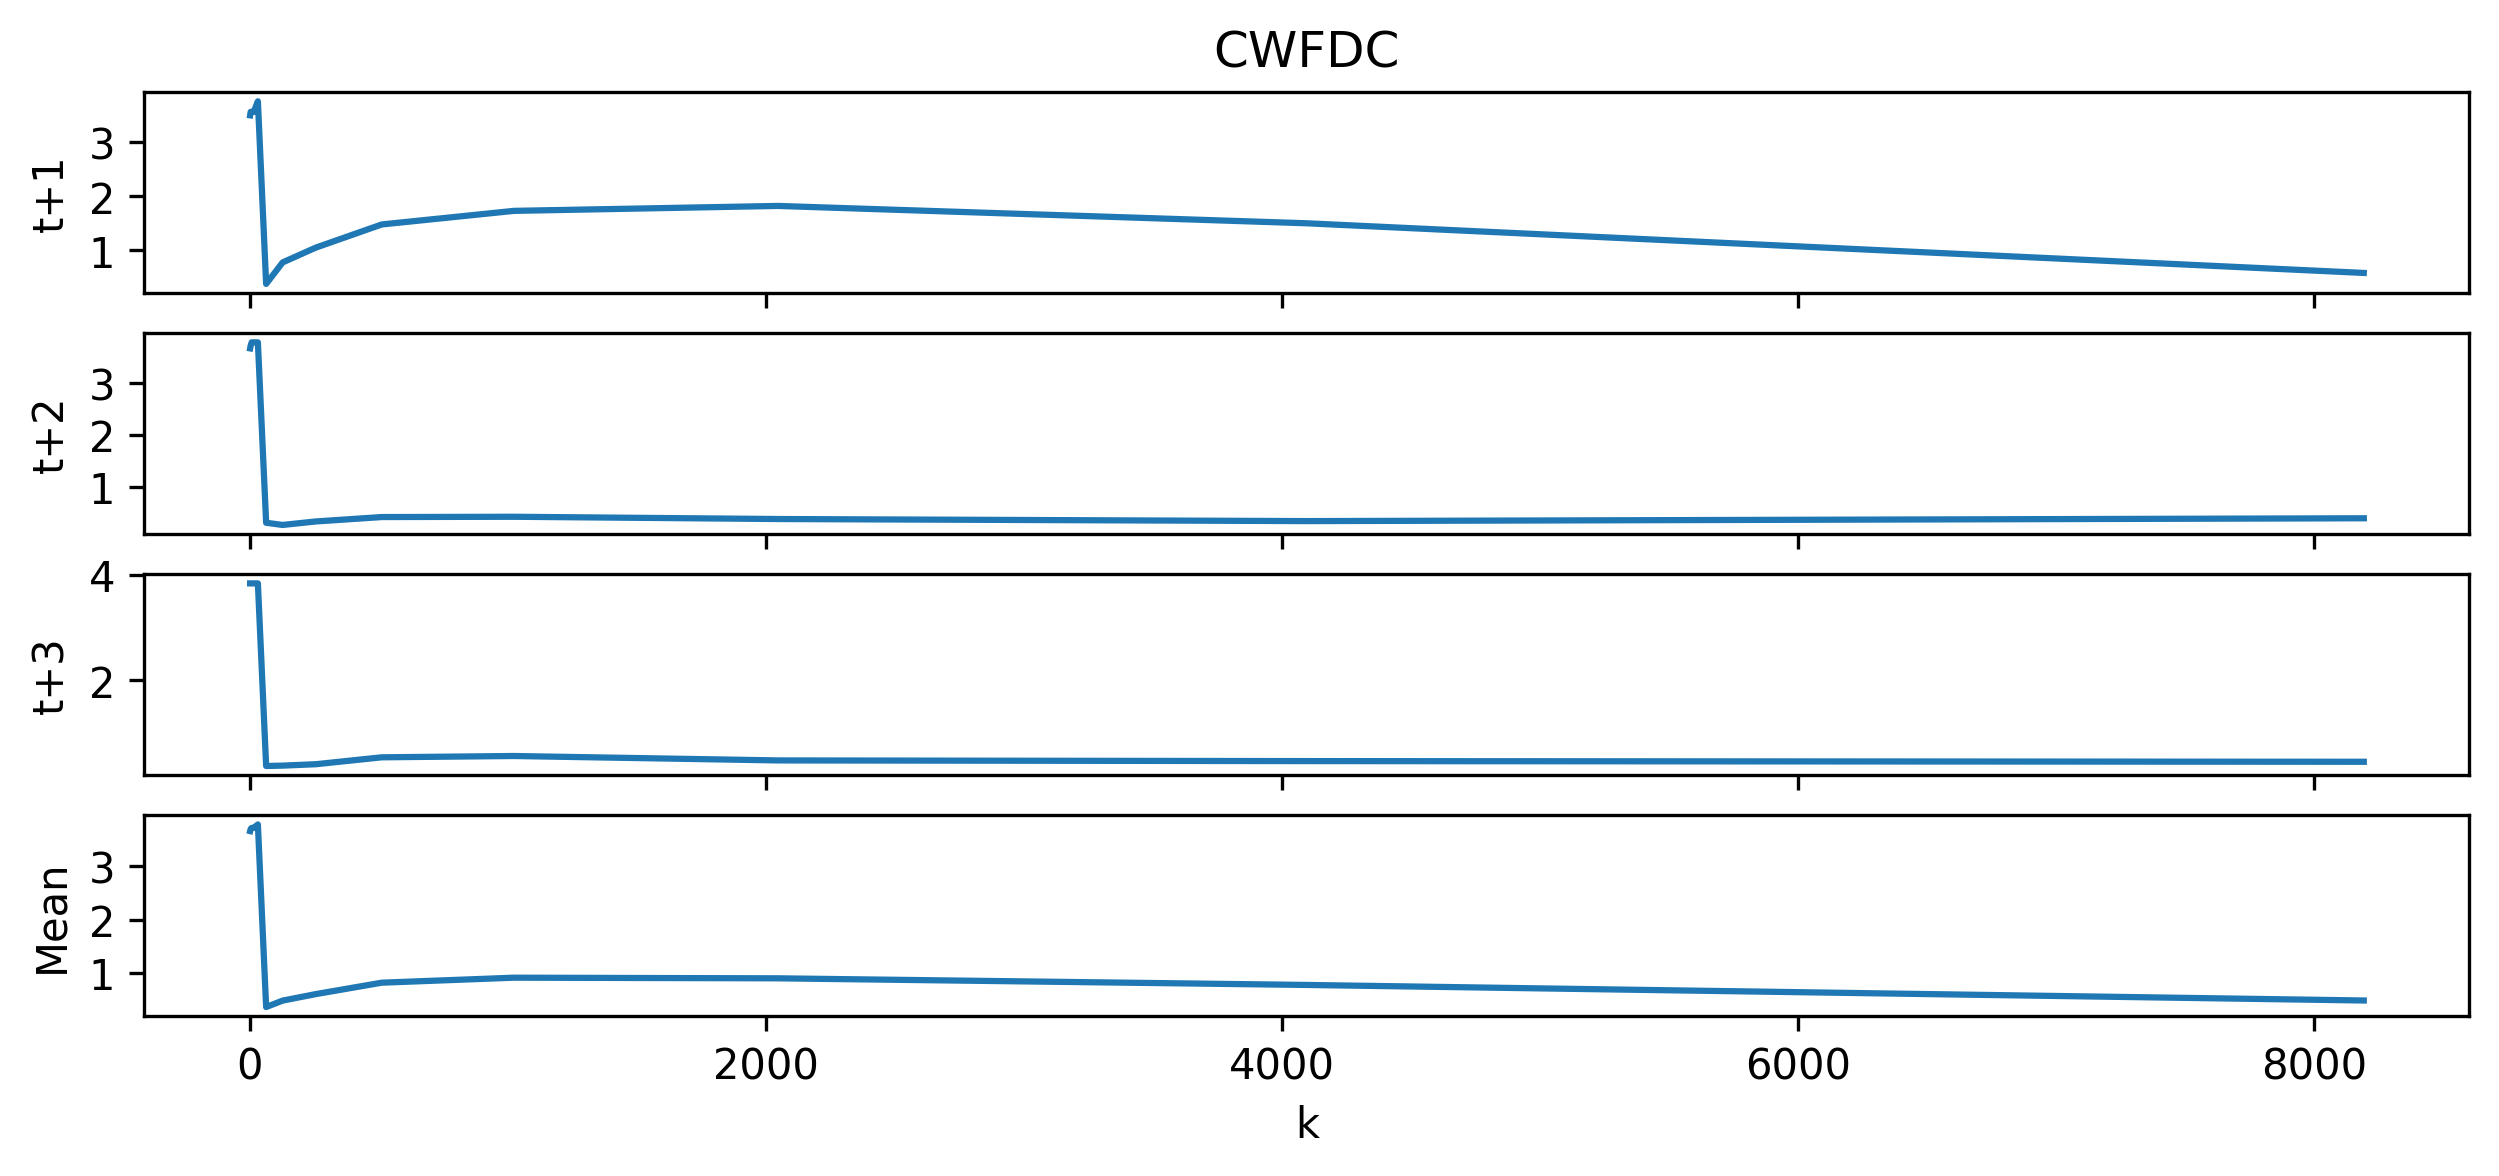

In [16]:
display_knn_ablation(knn_ablation_df)